# [**Estimation de covariance inverse creuse**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/2_6_covariance/plot_sparse_cov.ipynb)<br/>([_Sparse inverse covariance estimation_](https://scikit-learn.org/stable/auto_examples/covariance/plot_sparse_cov.html))

Ce notebook montre comment utiliser l'estimateur [**`GraphicalLasso`**](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.GraphicalLasso.html) pour apprendre une matrice de covariance et une matrice de précision creuse à partir d'un petit nombre d'échantillons.

Pour estimer un modèle probabiliste (par exemple, un modèle gaussien), l'estimation de la matrice de précision, c'est-à-dire la matrice de covariance inverse, est aussi importante que l'estimation de la matrice de covariance. En effet, un modèle gaussien est paramétré par la matrice de précision.

Pour être dans des conditions favorables de récupération, nous échantillonnons les données à partir d'un modèle avec une matrice de précision creuse. De plus, nous nous assurons que les données ne sont pas trop corrélées (en limitant le plus grand coefficient de la matrice de précision) et qu'il n'y a pas de petits coefficients dans la matrice de précision qui ne peuvent pas être récupérés. De plus, avec un petit nombre d'observations, il est plus facile de récupérer une matrice de corrélation plutôt qu'une matrice de covariance, nous mettons donc les séries temporelles à l'échelle.

Ici, le nombre d'échantillons est légèrement supérieur au nombre de dimensions, de sorte que la covariance empirique est toujours inversible. Cependant, comme les observations sont fortement corrélées, la matrice de covariance empirique est mal conditionnée et, par conséquent, son inverse - la matrice de précision empirique - est très éloignée de la vérité terrain.

Si nous utilisons un rétrécissement $\ell_2$, comme avec l'estimateur Ledoit-Wolf, puisque le nombre d'échantillons est petit, nous devons beaucoup rétrécir. En conséquence, la précision Ledoit-Wolf est assez proche de la précision de référence, qui n'est pas très éloignée d'être diagonale, mais la structure hors diagonale est perdue.

L'estimateur pénalisé $\ell_1$ peut récupérer une partie de cette structure hors diagonale. Il apprend une précision creuse. Il n'est pas capable de récupérer le motif de parcimonie exact : il détecte trop de coefficients non nuls. Cependant, les plus grands coefficients non nuls de l'estimation $\ell_1$ correspondent aux coefficients non nuls de la vérité terrain. Enfin, les coefficients de l'estimation de précision l1 sont biaisés vers zéro : en raison de la pénalité, ils sont tous plus petits que la valeur correspondante de la vérité terrain, comme on peut le voir sur la figure.

Notez que la gamme de couleurs des matrices de précision est ajustée pour améliorer la lisibilité de la figure. La gamme complète des valeurs de la précision empirique n'est pas affichée.

Le paramètre `alphaalpha du [**`GraphicalLasso`**](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.GraphicalLasso.html), qui règle la parcimonie du modèle, est défini par validation croisée interne dans le [**`GraphicalLassoCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.GraphicalLassoCV.html). Comme on peut le voir sur la figure 2, la grille pour calculer le score de validation croisée est affinée itérativement dans le voisinage du maximum.

In [1]:
# author: Gael Varoquaux <gael.varoquaux@inria.fr>
# License: BSD 3 clause
# Copyright: INRIA

# Générer les données

In [2]:
import numpy as np
from scipy import linalg

from sklearn.datasets import make_sparse_spd_matrix

n_samples = 60
n_features = 20

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(
    n_features, alpha=0.98, smallest_coef=0.4, largest_coef=0.7, random_state=prng
)
cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# Estimer la covariance

In [3]:
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf

emp_cov = np.dot(X.T, X) / n_samples

model = GraphicalLassoCV()
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

lw_cov_, _ = ledoit_wolf(X)
lw_prec_ = linalg.inv(lw_cov_)

# Tracer les résultats

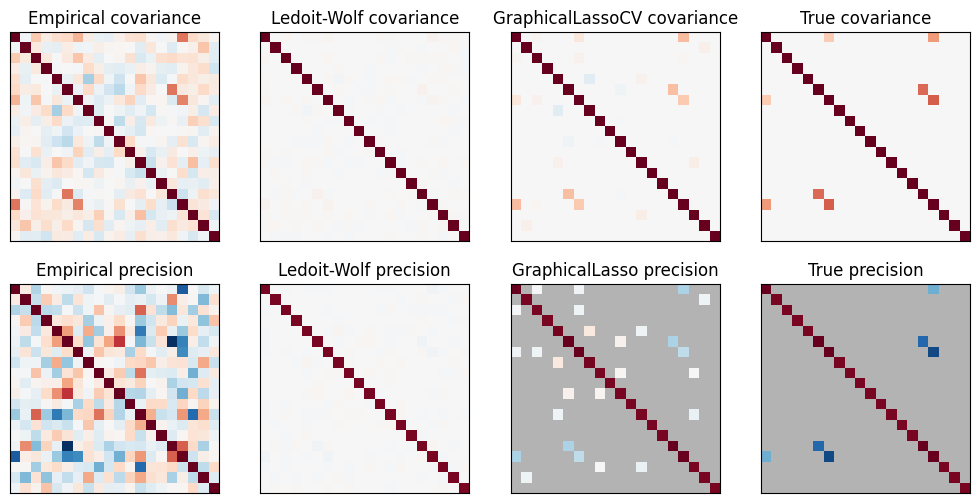

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [
    ("Empirical", emp_cov),
    ("Ledoit-Wolf", lw_cov_),
    ("GraphicalLassoCV", cov_),
    ("True", cov),
]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(
        this_cov, interpolation="nearest", vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r
    )
    plt.xticks(())
    plt.yticks(())
    plt.title(f"{name} covariance")


# plot the precisions
precs = [
    ("Empirical", linalg.inv(emp_cov)),
    ("Ledoit-Wolf", lw_prec_),
    ("GraphicalLasso", prec_),
    ("True", prec),
]
vmax = 0.9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(
        np.ma.masked_equal(this_prec, 0),
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
        cmap=plt.cm.RdBu_r,
    )
    plt.xticks(())
    plt.yticks(())
    plt.title(f"{name} precision")
    if hasattr(ax, "set_facecolor"):
        ax.set_facecolor(".7")
    else:
        ax.set_axis_bgcolor(".7")

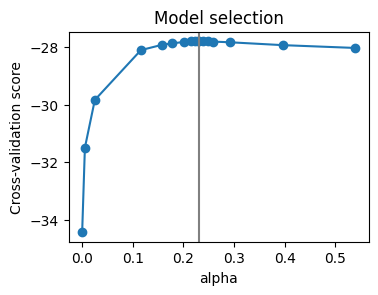

In [5]:
# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([0.2, 0.15, 0.75, 0.7])
plt.plot(model.cv_results_["alphas"], model.cv_results_["mean_test_score"], "o-")
plt.axvline(model.alpha_, color=".5")
plt.title("Model selection")
plt.ylabel("Cross-validation score")
plt.xlabel("alpha")

plt.show()